## Preço Dinâmico de Frete na OLX Pay
### Union Squad – Letícia Fiorito, Daniel Rocha, Everton Arruda, Allan Kildare
Por meio de um mecanismo de economia do compartilhamento, criamos uma área dentro do app da OLX para que usuário possam ser entregadores independentes. Assim, é criado um mecanismo de remuneração para oferecer a facilidade do comprador não precisar se deslocar para coletar o item comprado. 

O código deste arquivo fornece um mecanismo de otimização da experiência do usuário e do empregador por meio da criação de um algoritimo de preço dinâmico do frete. A solução apresentada também otimiza a logística reversa, pois o entregador autônomo também pode transportar produtos que precisem ser trocados ou retificados.

### Importando bibliotecas e fazendo ajustes visuais

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [239]:
for m,n in zip(["display.max_columns","display.max_rows"], [None,10]):
    pd.set_option(m,n)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color','axes.titlesize',
    'figure.figsize','legend.framealpha'],['white','white','white','white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

### Importando os dados

In [228]:
for i in ['customers','orders','order_items','sellers','products','geolocation']:
    globals()[str(i)] = pd.read_csv('/Users/pedrocerbino/Downloads/archive/olist_' + str(i) + '_dataset.csv')

In [14]:
orders.head().T[[0,1,2]]

,0,1,2
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [22]:
order_items.head().T[[0,1,2]]

,0,1,2
order_id,00010242fe8c5a6d1ba2dd792cb16214,00018f77f2f0320c557190d7a144bdd3,000229ec398224ef6ca0657da4fc703e
order_item_id,1,1,1
product_id,4244733e06e7ecb4970a6e2683c13e61,e5f2d52b802189ee658865ca93d83a8f,c777355d18b72b67abbeef9df44fd0fd
seller_id,48436dade18ac8b2bce089ec2a041202,dd7ddc04e1b6c2c614352b383efe2d36,5b51032eddd242adc84c38acab88f23d
shipping_limit_date,2017-09-19 09:45:35,2017-05-03 11:05:13,2018-01-18 14:48:30
price,58.9,239.9,199
freight_value,13.29,19.93,17.87


In [18]:
products.head().T[[0,1,2]]

,0,1,2
product_id,1e9e8ef04dbcff4541ed26657ea517e5,3aa071139cb16b67ca9e5dea641aaa2f,96bd76ec8810374ed1b65e291975717f
product_category_name,perfumaria,artes,esporte_lazer
product_name_lenght,40,44,46
product_description_lenght,287,276,250
product_photos_qty,1,1,1
product_weight_g,225,1000,154
product_length_cm,16,30,18
product_height_cm,10,18,9
product_width_cm,14,20,15


### Realizamos uma aproximação do CEP
O endereço exato não é divulgado por motivos de privacidade, mas os primeiros dígitos do CEP são suficientes para estimar a distância da entrega

In [ ]:
geolocation = geolocation.groupby('geolocation_zip_code_prefix',as_index=False).median()
geolocation.head().T[[0,1,2]]

In [233]:
for i in ['sellers','customers']:
    globals()[str(i)] = globals()[str(i)][[i[:-1]+'_zip_code_prefix',i[:-1]+'_id']].merge(geolocation[['geolocation_zip_code_prefix','geolocation_lat',
    'geolocation_lng']],left_on=i[:-1]+'_zip_code_prefix',right_on='geolocation_zip_code_prefix')

In [32]:
customers.head().T[[0,1,2]]

,0,1,2
customer_zip_code_prefix,14409,14409,14409
customer_id,06b8999e2fba1a1fbc88172c00ba8bc7,5dca924cc99eea2dc5ba40d11ec5dd0f,661897d4968f1b59bfff74c7eb2eb4fc
geolocation_zip_code_prefix,14409,14409,14409
geolocation_lat,-20.5021,-20.5021,-20.5021
geolocation_lng,-47.3968,-47.3968,-47.3968


In [63]:
sellers.head().T[[0,1,2]]

,0,1,2
seller_id,3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d
seller_zip_code_prefix,13023,13844,20031
seller_city,campinas,mogi guacu,rio de janeiro
seller_state,SP,SP,RJ


### Agregamos todas as tabelas

In [124]:
freight = order_items[['freight_value','order_id','product_id','seller_id']].merge(
            sellers[['seller_id','geolocation_lat','geolocation_lng']],on='seller_id').merge(
            orders[['order_id','customer_id']],on='order_id').merge(
            customers[['customer_id','geolocation_lat','geolocation_lng']],on='customer_id').merge(
            products[['product_id','product_weight_g','product_length_cm','product_height_cm',
            'product_width_cm']],on='product_id')
freight.drop(inplace=True,columns=['product_id','seller_id','customer_id'])

### Calculamos a distância geodésica

In [125]:
import geopy.distance
distance = []
for i,k,m,n in zip(freight.geolocation_lat_x,freight.geolocation_lng_x,freight.geolocation_lat_y,
                   freight.geolocation_lng_y):
    dist = geopy.distance.geodesic((i,k),(m,n))
    distance.append(dist.meters)
freight.insert(1,'distance',distance)
freight.distance = freight.distance/1000 # distancia aproximada em quilômetros
freight.insert(2,'volume',
               freight.product_length_cm*freight.product_height_cm*freight.product_width_cm)
freight.drop(inplace=True,columns=['geolocation_lat_x','geolocation_lng_x','geolocation_lat_y',
                 'geolocation_lng_y','product_height_cm','product_length_cm','product_width_cm'])
freight

,freight_value,distance,volume,order_id,product_weight_g
0,13.29,301.582449,3528.0,00010242fe8c5a6d1ba2dd792cb16214,650.0
1,17.96,943.388764,3528.0,130898c0987d1801452a8ed92a670612,650.0
2,18.33,286.376775,3528.0,532ed5e14e24ae1f0d735b91524b98b9,650.0
3,16.17,608.756442,3528.0,6f8c31653edb8c83e1a739408b5ff750,650.0
4,13.29,206.466450,3528.0,7d19f4ef4d04461989632411b7e588b9,650.0
...,...,...,...,...,...
112091,16.14,654.387217,8349.0,fdaf98feac227eb978d8f33f36e0231d,1000.0
112092,16.21,365.422597,3825.0,fe68b52db13993f58175fa589125d345,500.0
112093,193.21,1172.553303,45684.0,fefacc66af859508bf1a7934eab1e97f,5660.0
112094,14.44,105.074566,13718.0,ff701a7c869ad21de22a6994237c8a00,2000.0


### Visualizamos os dados

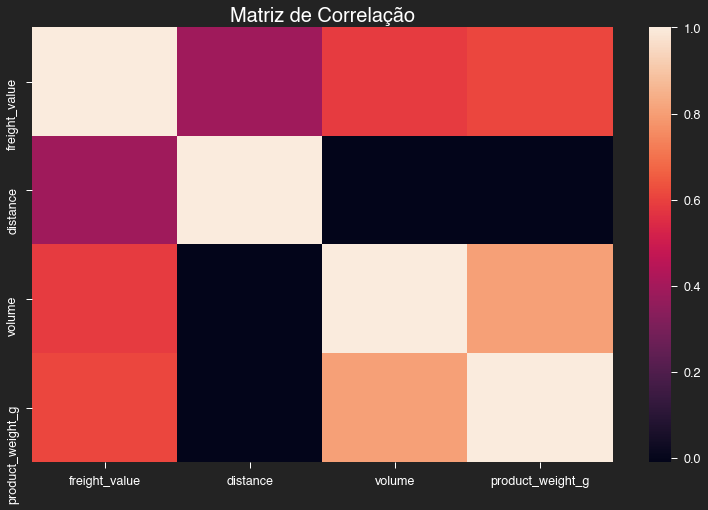

In [186]:
sns.heatmap(freight.corr())
plt.title('Matriz de Correlação');

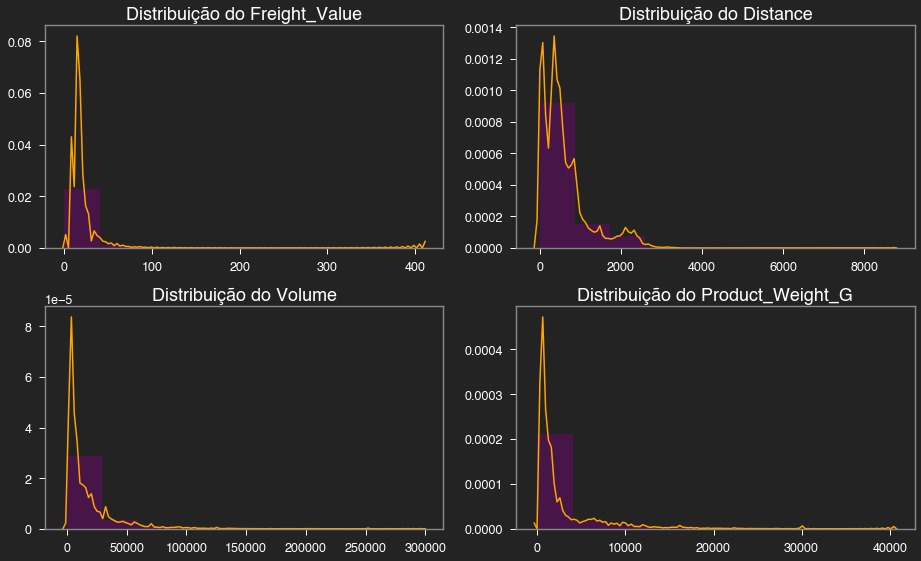

In [213]:
plt.figure()
for k,j in zip([1,2,3,4],['freight_value','distance','volume','product_weight_g']):
    plt.subplot(2, 2, k)
    sns.distplot(freight[j],bins=10,color='purple',kde_kws={"color":"orange"})
    plt.title('Distribuição do '+j.title(), size=18)
    plt.xlabel('')
plt.tight_layout()

### Plotamos a relação entre os dados

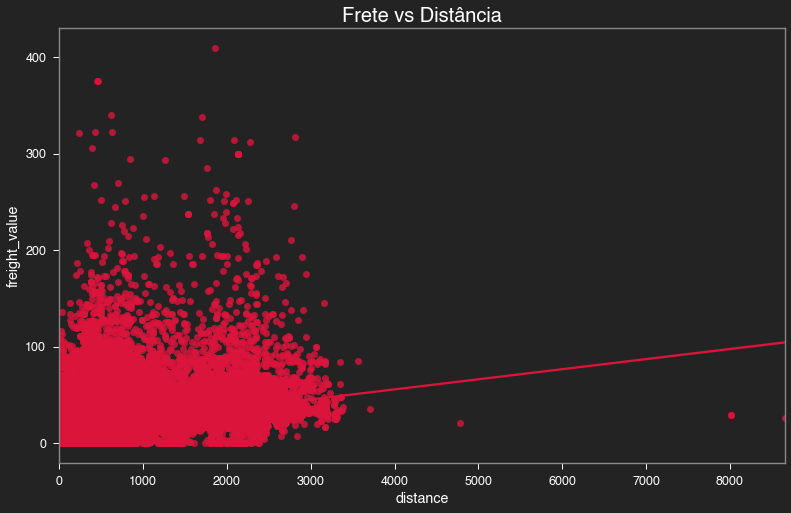

In [242]:
sns.regplot(x='distance',y='freight_value',data=freight,color='crimson')#volume,product_weight_g)
plt.title('Frete vs Distância');

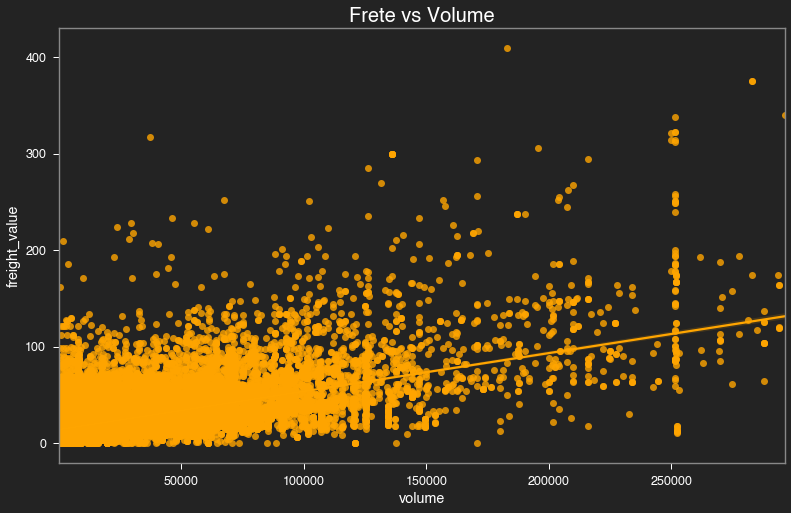

In [220]:
sns.regplot(x='volume',y='freight_value',data=freight,color='orange')
plt.title('Frete vs Volume');

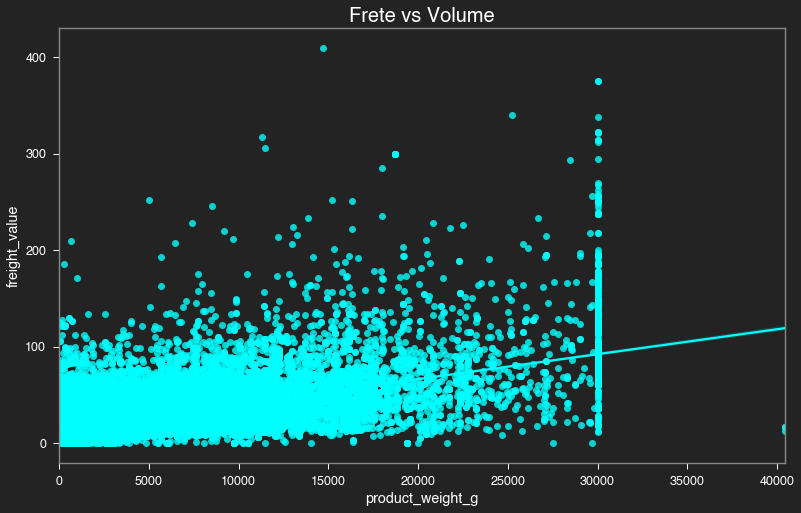

In [241]:
sns.regplot(x='product_weight_g',y='freight_value',data=freight,color='aqua')
plt.title('Frete vs Volume');

### Equacionamos o Modelo
Consideramos que existe um valor mínimo de frete ($\alpha$) que é incrementado a partir de variáveis exógenas ponderadas pelos seus respectivos coeficientes ($\beta_i$). O resíduo representa as variáveis omitidas

$Frete = \alpha + \beta_1\cdot Distancia + \beta_3\cdot Peso + \beta_2\cdot Volume + Residuo$

#### Em um cenário com mais dados, poderíamos desmembrar o resíduo em dados de trânsito previsto, previsões pluviométricas e limitação do número de entregadores

In [226]:
import statsmodels.api as sm
X, y = freight[['distance','product_weight_g','volume']], freight.freight_value
X = sm.add_constant(X)
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          freight_value   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 4.667e+04
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:57:09   Log-Likelihood:            -4.2309e+05
No. Observations:              112078   AIC:                         8.462e+05
Df Residuals:                  112074   BIC:                         8.462e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.3629      0.049    148.834      0.000       7.266       7.460
distance             0.0106   5.36e-05    197.937      0.000       0.010       0.011
product_weight_g     0.0017   1.42e-05    117.150      0.000       0.002       0.002
volume               0.0002   2.26e-06     82.090      0.000       0.000       0.000
==============================================================================
Omnibus:                   118063.786   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27355087.937
Skew:                           4.867   Prob(JB):                         0.00
Kurtosis:                      78.914   Cond. No.                     4.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Pelo modelo, vemos que há uma explicação estatísticamente significante, conseguindo prever 55,5% do preço do frete

### Estimando os parâmetros

In [110]:
est.params

const               7.362944
distance            0.010601
product_weight_g    0.001659
volume              0.000186
dtype: float64

$Preço = 7.362944 + 0.010601\cdot Distancia + 0.001659\cdot Peso + 0.000186\cdot Volume + Residuo$

### Plotando Partial Regression

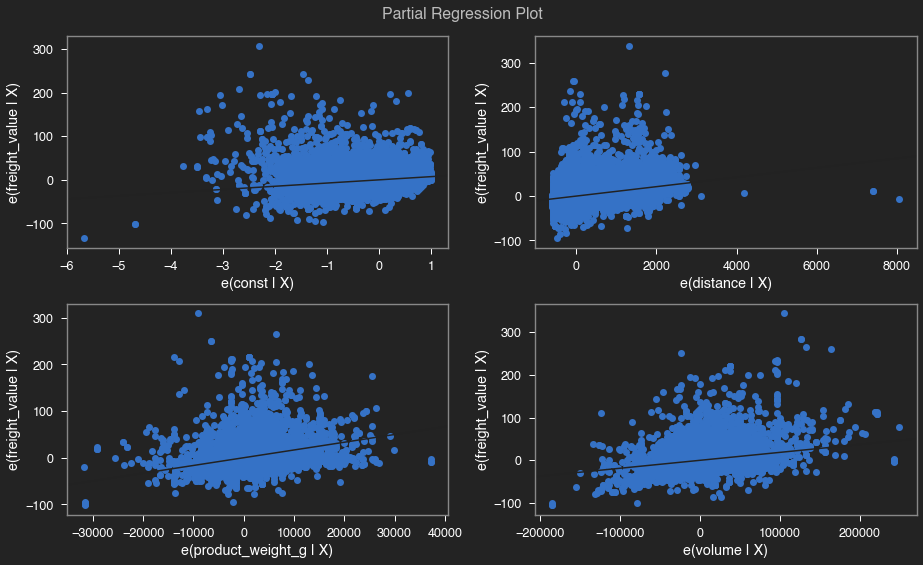

In [227]:
fig = sm.graphics.plot_partregress_grid(est)
fig.tight_layout(pad=1.0)

### Plotando Fitted Values
Em vermelho estão as observações incluídas no modelo. Em azul, as que não conseguiram ser previstas.

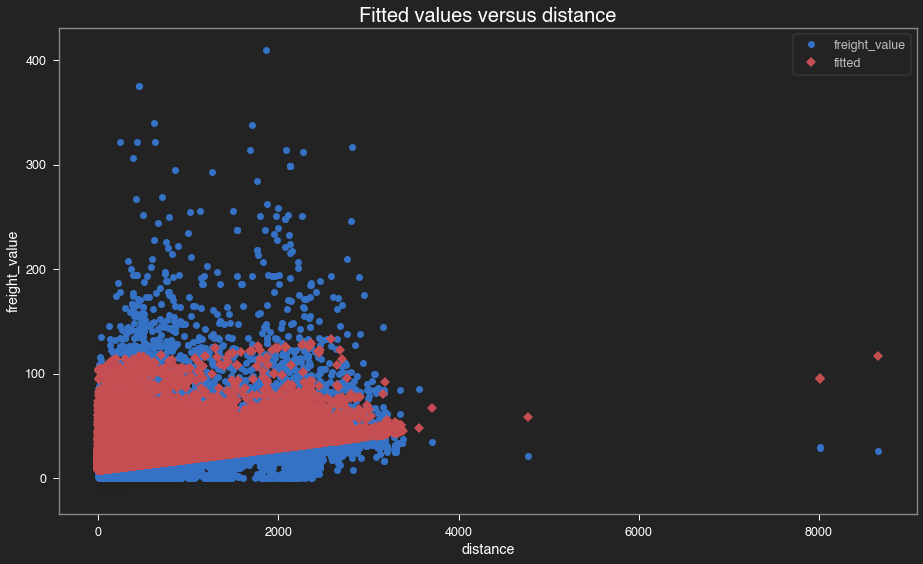

In [106]:
fig = sm.graphics.plot_fit(est, 'distance')
fig.tight_layout(pad=1.0)

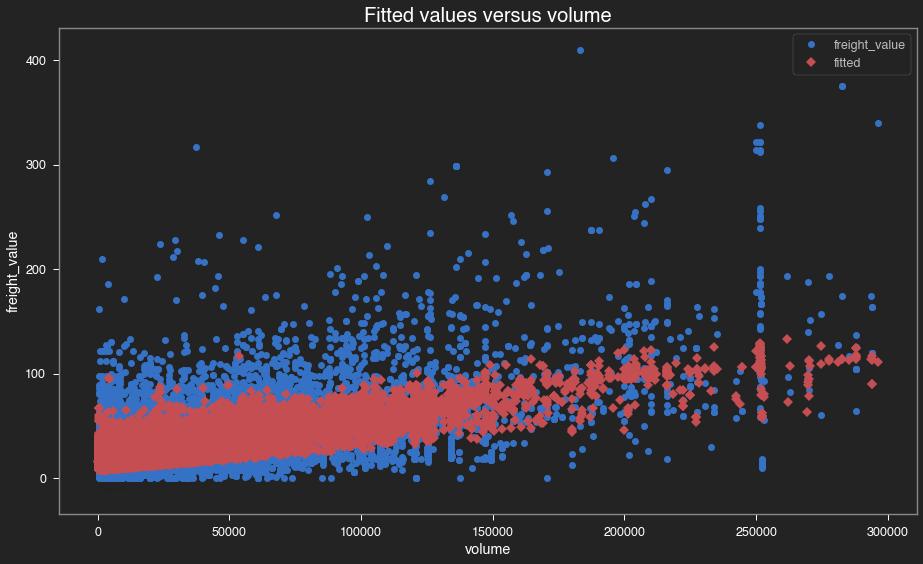

In [107]:
fig = sm.graphics.plot_fit(est, 'volume')
fig.tight_layout(pad=1.0)

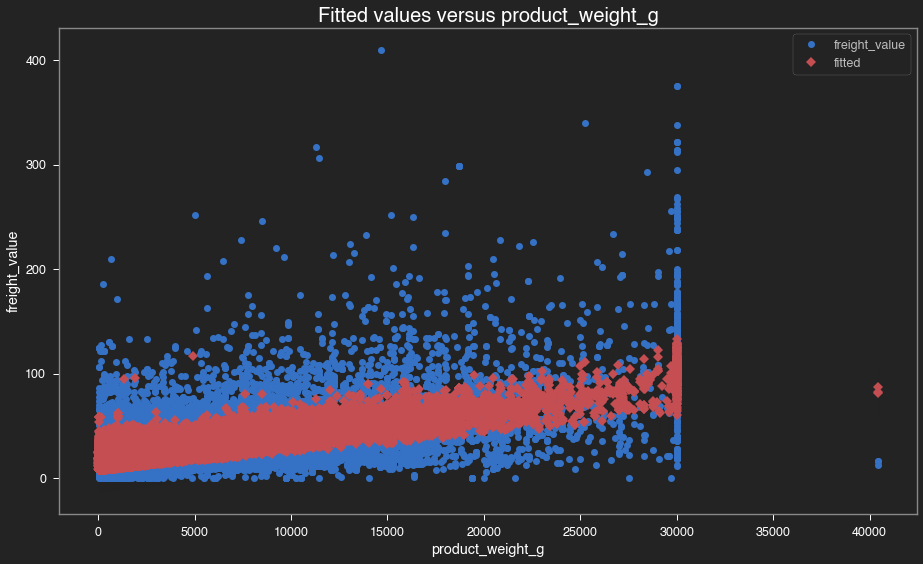

In [108]:
fig = sm.graphics.plot_fit(est, 'product_weight_g')
fig.tight_layout(pad=1.0)